In [39]:
import pandas as pd
import numpy as np
import datetime as dt

import scipy.stats as stats
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm import tqdm

# Проверка качества сплитования
> Задача А/А тестов определить насколько корректно работает система сплитования, чтобы не отвергать ошибочно нулевую гипотезу

## Этапы проверки сплитования
1. <b>Sample Ratio Mismatch (SRM) Check</b> – проверка честного деления пользователей между группами
2. <b>Intersection Check</b> – проверка пересечения пользователей между сплитами
3. <b>False Positive Rate (FPR) Check</b> – проверка ложноположительной вероятности с помощью бизнес-метрик

#### Сгенерим данные

In [2]:
def data_gen(l, n, k, g):
    """
        l: длительность эксперимента
        n: кол-во юзеров
        k: коэффициент увеличения группы 2
        g: количество групп
    """

    # Временной период
    days = []
    for day in range(1,l+1):
        days.append((dt.datetime.today() - dt.timedelta(days=day)).strftime('%Y-%m-%d'))
    
    # Пользователи
    count = n
    users = []
    for user in np.random.randint(10000,90000,count):
        user_id = hash(user)
        users.append(user_id)
    
    # Объедине юзеров по дням
    days_df = pd.DataFrame(days).rename(columns={0:'date'})
    users_df = pd.DataFrame(users).rename(columns={0:'user_id'})
    
    traffic = days_df.merge(
        users_df,
        how='cross'
    )
    
    # Генерация метрики
    metrics = []
    for user in users:
        user_metrics = np.random.exponential(10,14)
        metrics.append(user_metrics)
    
    metric = pd.DataFrame(pd.Series(metrics).explode()).rename(columns={0:'metric'})

    # Объединение метрики и трафика
    data = pd.concat([traffic, metric.set_index(traffic.index)], axis=1)

    # Сплитование юзеров
    split = []
    for user in users:
        group = np.random.randint(1,g+1)
        split.append(group)
    
    splits = pd.concat(\
        [pd.DataFrame(users).rename(columns={0:'user_id'}), \
         pd.DataFrame(split).rename(columns={0:'split'})], axis=1)
    
    # Финальная сборка
    data = data.merge(
        splits,
        how='left',
        left_on='user_id',
        right_on='user_id'
    )
    
    data.loc[data.split == 2, 'metric'] = data.loc[data.split == 2, 'metric'] * k
    
    return data

In [3]:
data = data_gen(n=10000, l=14, k=1.1, g=3)
data.head()

,date,user_id,metric,split
0,2022-05-02,26630,9.015592,2
1,2022-05-02,56791,10.608858,3
2,2022-05-02,37224,4.464899,2
3,2022-05-02,89820,17.998514,2
4,2022-05-02,13973,0.182132,1


### Sample Ratio Mismatch (SRM) Check 
- Необходим для проверки равномерности распределения пользователей по веткам эксперимента и разным группам.

In [4]:
from scipy.stats import chisquare

In [5]:
# Кол-во юзеров для каждой группы
count_by_split = data.groupby('split')[['user_id']].count().reset_index()
# Доля юзеров в каждой группе
count_by_split['share'] = count_by_split.apply(lambda x: x/sum(x))['user_id']
count_by_split

,split,user_id,share
0,1,50848,0.324170
1,2,54152,0.345234
2,3,51856,0.330596


- Визуально кажется, что группы совпадают по долям
- Применим Хи-квадрат, чтобы оценить разницу долей статитсически
> Мы видим p-value выше 0.05, поэтому делаем заключение, что группы по долям не отличаются

In [14]:
chisquare((count_by_split.user_id[1], count_by_split.user_id[2]))

Power_divergenceResult(statistic=49.728473322768096, pvalue=1.7656483332214082e-12)

### Intersection Check
- Важно обращать внимание на то, как распределены сами сплиты
    - Если они изначально заданы как 50/50, то на данных распределение должно быть максимально приближено к этим значениям

In [34]:
splits = list(set(data.split))
splits_intersection = dict({})

for split_a in splits:
    split_b_list = []
    for split_b in splits:
        group_a = data[data.split == split_a]
        group_b = data[data.split == split_b]
        
        slits_merge = group_a.merge(
            group_b,
            how='inner',
            left_on='user_id',
            right_on='user_id'
        ).user_id
        
        split_b_list.append(slits_merge.count() / group_b.count().user_id)
        
    splits_intersection[split_a] = split_b_list

In [35]:
split_b_list

[2.0583700440528636, 2.2440537745604963, 19.73002159827214]

In [36]:
splits_intersection

{1: [19.1420704845815, 2.229576008273009, 2.0183585313174945],
 2: [2.3744493392070485, 19.36401240951396, 2.3434125269978403],
 3: [2.0583700440528636, 2.2440537745604963, 19.73002159827214]}

In [69]:
data.pivot_table(
    data, 
    columns='split',
    index='split',
    aggfunc='count'
).user_id

split,1,2,3
split,,,
1,52696.0,NaN,NaN
2,NaN,52780.0,NaN
3,NaN,NaN,52584.0


### False Positive Rate (FPR) Check
1. Проводим A/A тест. 
    - Время на A/A определяется таким образом, чтобы охватить как можно больше факторов влияния на метрику (например, недельная сезонность)
2. Симулируем новые A/A.
    - Тест пересчитывается ≥10тыс. раз при помощи симуляции новых A/A
3. Считаем стат.значимость.
    - В каждом тесте считается p-value при помощи статистического оценщика (бутстрап, т-тест и т.п.)
4. Считаем метрику качества FPR (False Positive Rate)
$$
FPR = \frac{FP}{FP+TN}; (FP+TN = N)
$$
5. Делаем выводы. Проверяется условие FPR < α, и если условие соблюдается, то сплитовалка работает корректно
    - Это становится возможным, поскольку при верной нулевой гипотезе распределение всегда будет uniform

#### Сгенерим данные

In [43]:
n = 100000

df = pd.DataFrame({
    "s1": np.random.exponential(scale=1/0.001, size=n),
    "s2": np.random.exponential(scale=1/0.001, size=n)
})
df.head()

,s1,s2
0,2276.078262,397.280407
1,1094.859666,817.607013
2,615.371318,208.008659
3,1738.848889,688.255900
4,202.664197,715.309557


#### Запустим симуляцию А/А теста

In [47]:
simulations = 1000
sample_n = 1000
p_value_list = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df['s1'].sample(sample_n).values
    s2 = df['s2'].sample(sample_n).values
    p_value_list.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.11it/s]


In [48]:
p_value_list[:5]

[0.4246077948545297,
 0.4042080051007312,
 0.8949825051733448,
 0.6068223122201739,
 0.7688209417148324]

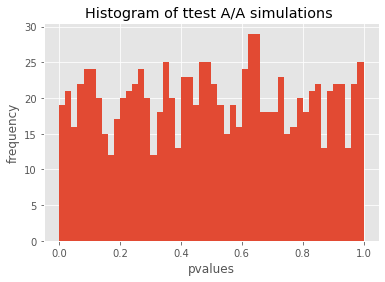

In [55]:
plt.hist(p_value_list, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [57]:
# Проверяем, что количество ложноположительных случаев не превышает альфа
def fpr(p_value_list):
    return sum(np.array(p_value_list) < .05) / simulations

print(f'False Positive Rate: {fpr(p_value_list)}')

False Positive Rate: 0.045
